In [991]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [992]:
df = pd.read_csv('cleaned_data_new.csv', index_col='customer_id')
df.head()

SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
customer_id                                                      
0                           6               2                2   
2                          11               2                2   
3                          11               2                2   
4                           5               5                2   
6                           2               2                2   

             SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
customer_id                                                                     
0                                3                    1                     1   
2                                4                    1                     1   
3                                1                    1                     1   
4                                1                    1                     1   
6                                1                    1                     1   

             SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  \
customer_id                                                       
0                                    4                        1   
2                                    7                        1   
3                                   10                        1   
4                                    4                        4   
6                                    1                        1   

             LONG_TERM_COUNT_NON_BANK  NUMBER_OF_LOANS  ...  \
customer_id                                             ...   
0                                   1                5  ...   
2                                   1               11  ...   
3                                   1               11  ...   
4                                   1                8  ...   
6                                   1                2  ...   

             ENQUIRIES_FROM_BANK_9M_12M  ENQUIRIES_FROM_BANK_6M_12M  \
customer_id                                                           
0                                     2                           2   
2                                     2                           2   
3                                     2                           2   
4                                     5                           3   
6                                     2                           2   

             ENQUIRIES_FROM_BANK_3M_12M  ENQUIRIES_FROM_NON_BANK_3M_6M  \
customer_id                                                              
0                                     2                              7   
2                                     2                              7   
3                                     2                              7   
4                                     2                              6   
6                                     2                              2   

             ENQUIRIES_FROM_NON_BANK_6M_9M  ENQUIRIES_FROM_NON_BANK_9M_12M  \
customer_id                                                                  
0                                        7                               7   
2                                        7                               7   
3                                        7                               5   
4                                        6                               6   
6                                        2                               2   

             ENQUIRIES_FROM_NON_BANK_6M_12M  ENQUIRIES_FROM_NON_BANK_3M_12M  \
customer_id                                                                   
0                                         7                               7   
2                                         7                               7   
3                                         5                               5   
4                                         5                               5   
6                               

### 1. Lọc dữ liệu

#### Lựa chọn biến đầu vào

Dựa trên dữ liệu đã phân tích từ vòng 2, nhóm đã quyết định điều chỉnh hoặc các trường dữ liệu sau khỏi biến đầu vào. 

In [993]:
outstanding_cols = [col for col in df.columns if 'outstanding' in col.lower() and 'augmented' not in col.lower()]
outstanding_cols

['OUTSTANDING_BAL_LOAN_CURRENT',
 'OUTSTANDING_BAL_LOAN_3M',
 'OUTSTANDING_BAL_LOAN_6M',
 'OUTSTANDING_BAL_LOAN_9M',
 'OUTSTANDING_BAL_LOAN_12M',
 'OUTSTANDING_BAL_CC_3M',
 'OUTSTANDING_BAL_CC_6M',
 'OUTSTANDING_BAL_CC_9M',
 'OUTSTANDING_BAL_CC_12M',
 'OUTSTANDING_BAL_ALL_3M',
 'OUTSTANDING_BAL_ALL_6M',
 'OUTSTANDING_BAL_ALL_9M',
 'OUTSTANDING_BAL_ALL_12M',
 'OUTSTANDING_BAL_LOAN_3M_6M',
 'OUTSTANDING_BAL_LOAN_6M_9M',
 'OUTSTANDING_BAL_LOAN_9M_12M',
 'OUTSTANDING_BAL_LOAN_6M_12M',
 'OUTSTANDING_BAL_LOAN_3M_12M',
 'OUTSTANDING_BAL_CC_3M_6M',
 'OUTSTANDING_BAL_CC_6M_9M',
 'OUTSTANDING_BAL_CC_9M_12M',
 'OUTSTANDING_BAL_CC_6M_12M',
 'OUTSTANDING_BAL_CC_3M_12M',
 'OUTSTANDING_BAL_ALL_3M_6M',
 'OUTSTANDING_BAL_ALL_6M_9M',
 'OUTSTANDING_BAL_ALL_9M_12M',
 'OUTSTANDING_BAL_ALL_6M_12M',
 'OUTSTANDING_BAL_ALL_3M_12M',
 'OUTSTANDING_BAL_CC_CURRENT',
 'OUTSTANDING_BAL_ALL_CURRENT']

In [994]:
# def min_max_normalize(data):
#     return (data - data.min()) / (data.max() - data.min())

# augmented_cols = [col+'_AUGMENTED' for col in outstanding_cols]
# df[augmented_cols] = min_max_normalize(df[outstanding_cols])

In [995]:
df.iloc[:, -20:].describe()

ENQUIRIES_FROM_NON_BANK_FOR_LOAN_12M  ENQUIRIES_FROM_BANK_FOR_CC_12M  \
count                          20000.000000                    20000.000000   
mean                              12.660650                        6.819300   
std                                6.790876                       10.252775   
min                                2.000000                        2.000000   
25%                                7.000000                        2.000000   
50%                               12.000000                        2.000000   
75%                               17.000000                        7.000000   
max                               82.000000                      142.000000   

       ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  ENQUIRIES_3M_6M  ENQUIRIES_6M_9M  \
count                        20000.000000     20000.000000     20000.000000   
mean                             2.917750         6.217250         6.394700   
std                              2.795975         1.236094         1.117933   
min                              2.000000         2.000000         2.000000   
25%                              2.000000         6.000000         6.000000   
50%                              2.000000         7.000000         7.000000   
75%                              2.000000         7.000000         7.000000   
max                             52.000000         7.000000         7.000000   

       ENQUIRIES_9M_12M  ENQUIRIES_6M_12M  ENQUIRIES_3M_12M  \
count      20000.000000      20000.000000      20000.000000   
mean           6.535850          6.084400          5.548200   
std            0.996074          1.323618          1.571592   
min            2.000000          2.000000          2.000000   
25%            7.000000          5.000000          4.000000   
50%            7.000000          7.000000          6.000000   
75%            7.000000          7.000000          7.000000   
max            7.000000          7.000000          7.000000   

       ENQUIRIES_FROM_BANK_3M_6M  ENQUIRIES_FROM_BANK_6M_9M  \
count               20000.000000               20000.000000   
mean                    3.636850                   4.006200   
std                     1.699093                   1.856134   
min                     2.000000                   2.000000   
25%                     3.000000                   3.000000   
50%                     3.000000                   3.000000   
75%                     4.000000                   6.000000   
max                     7.000000                   7.000000   

       ENQUIRIES_FROM_BANK_9M_12M  ENQUIRIES_FROM_BANK_6M_12M  \
count                20000.000000                20000.000000   
mean                     4.267100                    3.824200   
std                      1.939187                    1.779397   
min                      2.000000                    2.000000   
25%                      3.000000                    3.000000   
50%                      3.000000                    3.000000   
75%                      7.000000                    5.000000   
max                      7.000000                    7.000000   

       ENQUIRIES_FROM_BANK_3M_12M  ENQUIRIES_FROM_NON_BANK_3M_6M  \
count                20000.000000                   20000.000000   
mean                     3.332100                       6.492450   
std                      1.544419                       1.062967   
min                      2.000000                       2.000000   
25%                      2.000000                       7.000000   
50%                      3.000000                       7.000000   
75%                      3.000000                       7.000000   
max                      7.000000                       7.000000   

       ENQUIRIES_FROM_NON_BANK_6M_9M  ENQUIRIES_FROM_NON_BANK_9M_12M  \
count                   20000.000000                    20000.000000   
mean                        6.618500                        6.717500   
std                         0.96

In [996]:
# drop_cols = [col for col in df.columns if 'OUTSTANDING' in col and 'AUGMENTED' not in col]
drop_cols = ['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT']
df.drop(drop_cols, axis=1, inplace=True)

In [997]:
# df.drop(drop_cols, axis=1, inplace=True)

In [998]:
X = df.drop(columns=['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [999]:
param = {'num_leaves': 75, 'objective': 'binary'}
param['metric'] = 'auc'

t1 = time.time()
num_round = 100
bst = lgb.train(param, train_data, num_round)
t2 = time.time()
t_lgb = t2 - t1

[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9918
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597


In [1000]:
ybar_proba_lgm = bst.predict(X_train)
ybar_lgm = [1 if x >= 0.5 else 0 for x in ybar_proba_lgm]
ypred_proba_lgm = bst.predict(X_test)
ypred_lgm = [1 if x >= 0.5 else 0 for x in ypred_proba_lgm]
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_lgm)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_lgm)*100))
auc_lgm = roc_auc_score(y_test, ypred_proba_lgm)
print('AUC: {}'.format(auc_lgm))
print('Gini: {}'.format(2*auc_lgm-1))

Accuracy for train data: 98.53125%
Accuracy for validation data: 91.725%
AUC: 0.9003815799902625
Gini: 0.8007631599805249


In [1001]:
df[df['label']==1].describe()

SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
count       3644.000000     3644.000000      3644.000000   
mean           4.606476        3.322997         2.025247   
std            3.060184        2.356903         0.265955   
min            2.000000        2.000000         2.000000   
25%            2.000000        2.000000         2.000000   
50%            5.000000        2.000000         2.000000   
75%            7.000000        5.000000         2.000000   
max           23.000000       17.000000         5.000000   

       SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
count            3644.000000          3644.000000           3644.000000   
mean                1.963502             1.276345              1.026345   
std                 1.645008             0.979998              0.276974   
min                 1.000000             1.000000              1.000000   
25%                 1.000000             1.000000              1.000000   
50%                 1.000000             1.000000              1.000000   
75%                 3.000000             1.000000              1.000000   
max                10.000000            10.000000              4.000000   

       SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  \
count                3644.000000              3644.000000   
mean                    2.664105                 2.050768   
std                     2.217569                 1.996676   
min                     1.000000                 1.000000   
25%                     1.000000                 1.000000   
50%                     1.000000                 1.000000   
75%                     4.000000                 3.000000   
max                    16.000000                13.000000   

       LONG_TERM_COUNT_NON_BANK  NUMBER_OF_LOANS  ...  \
count                    3644.0      3644.000000  ...   
mean                        1.0         6.000000  ...   
std                         0.0         4.283272  ...   
min                         1.0         2.000000  ...   
25%                         1.0         2.000000  ...   
50%                         1.0         5.000000  ...   
75%                         1.0         8.000000  ...   
max                         1.0        26.000000  ...   

       ENQUIRIES_FROM_BANK_9M_12M  ENQUIRIES_FROM_BANK_6M_12M  \
count                 3644.000000                 3644.000000   
mean                     3.737925                    3.477223   
std                      2.073103                    1.928670   
min                      2.000000                    2.000000   
25%                      2.000000                    2.000000   
50%                      3.000000                    3.000000   
75%                      7.000000                    5.000000   
max                      7.000000                    7.000000   

       ENQUIRIES_FROM_BANK_3M_12M  ENQUIRIES_FROM_NON_BANK_3M_6M  \
count                 3644.000000                    3644.000000   
mean                     3.096048                       6.253293   
std                      1.670199                       1.562954   
min                      2.000000                       2.000000   
25%                      2.000000                       7.000000   
50%                      2.000000                       7.000000   
75%                      3.000000                       7.000000   
max                      7.000000                       7.000000   

       ENQUIRIES_FROM_NON_BANK_6M_9M  ENQUIRIES_FROM_NON_BANK_9M_12M  \
count                    3644.000000                     3644.000000   
mean                        6.329583                        6.374588   
std                         1.540662                        1.518636   
min                         2.000000                        2.000000   
25%                         7.000000                        7.000000   
50%                         7.000000                        7.000000   
75%                    

In [1002]:
df[df['label']==0].describe()

SHORT_TERM_COUNT  MID_TERM_COUNT  LONG_TERM_COUNT  \
count      16356.000000    16356.000000     16356.000000   
mean           7.588347        4.549890         2.068293   
std            3.151968        3.148154         0.442383   
min            2.000000        2.000000         2.000000   
25%            5.000000        2.000000         2.000000   
50%            8.000000        4.000000         2.000000   
75%            8.000000        5.000000         2.000000   
max           26.000000       23.000000         8.000000   

       SHORT_TERM_COUNT_BANK  MID_TERM_COUNT_BANK  LONG_TERM_COUNT_BANK  \
count           16356.000000         16356.000000          16356.000000   
mean                3.447603             1.672292              1.067131   
std                 2.114198             1.578700              0.447985   
min                 1.000000             1.000000              1.000000   
25%                 1.000000             1.000000              1.000000   
50%                 4.000000             1.000000              1.000000   
75%                 4.000000             1.000000              1.000000   
max                13.000000            22.000000              7.000000   

       SHORT_TERM_COUNT_NON_BANK  MID_TERM_COUNT_NON_BANK  \
count               16356.000000             16356.000000   
mean                    4.117633                 2.883712   
std                     2.414185                 2.525284   
min                     1.000000                 1.000000   
25%                     3.000000                 1.000000   
50%                     4.000000                 1.000000   
75%                     5.000000                 4.000000   
max                    16.000000                19.000000   

       LONG_TERM_COUNT_NON_BANK  NUMBER_OF_LOANS  ...  \
count              16356.000000     16356.000000  ...   
mean                   1.002568        10.211788  ...   
std                    0.093798         4.143235  ...   
min                    1.000000         2.000000  ...   
25%                    1.000000         8.000000  ...   
50%                    1.000000        10.000000  ...   
75%                    1.000000        13.000000  ...   
max                    7.000000        35.000000  ...   

       ENQUIRIES_FROM_BANK_9M_12M  ENQUIRIES_FROM_BANK_6M_12M  \
count                16356.000000                16356.000000   
mean                     4.384996                    3.901504   
std                      1.888041                    1.735037   
min                      2.000000                    2.000000   
25%                      3.000000                    3.000000   
50%                      3.000000                    3.000000   
75%                      7.000000                    5.000000   
max                      7.000000                    7.000000   

       ENQUIRIES_FROM_BANK_3M_12M  ENQUIRIES_FROM_NON_BANK_3M_6M  \
count                16356.000000                   16356.000000   
mean                     3.384691                       6.545732   
std                      1.510010                       0.906608   
min                      2.000000                       2.000000   
25%                      2.000000                       7.000000   
50%                      3.000000                       7.000000   
75%                      3.000000                       7.000000   
max                      7.000000                       7.000000   

       ENQUIRIES_FROM_NON_BANK_6M_9M  ENQUIRIES_FROM_NON_BANK_9M_12M  \
count                   16356.000000                    16356.000000   
mean                        6.682869                        6.793898   
std                         0.763507                        0.613724   
min                         3.000000                        3.000000   
25%                         7.000000                        7.000000   
50%                         7.000000                        7.000000   
75%                    

In [1003]:
def check_corr(df, threshold):
    correlation = df.corr()
    for col in correlation.columns:
        for row in correlation.index:
            if correlation.loc[row, col] > threshold and row != col:
                return True
    return False

i=0
keep_cols = []
while check_corr(df, 0.5) and len(df.columns) > i+1 and len(df.columns) > 20:
    best_corr = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False).index[i+1]
    keep_cols.append(best_corr)
    correlation = df.corrwith(df[best_corr]).sort_values(ascending=False)
    for row in correlation.index:
        if abs(correlation[row]) > 0.5 and row not in keep_cols and row != best_corr:
            df.drop(row, axis=1, inplace=True)
            # print(row)
    i+=1
    print(len(df.columns))

101
89
85
85
77
77
73
60
41
39
37
37
34
34
34
34
25
24
21


In [1004]:
df.columns

Index(['LONG_TERM_COUNT', 'MID_TERM_COUNT_BANK', 'SHORT_TERM_COUNT_NON_BANK',
       'LONG_TERM_COUNT_NON_BANK', 'NUMBER_OF_LOANS', 'NUMBER_OF_CREDIT_CARDS',
       'NUMBER_OF_CREDIT_CARDS_NON_BANK', 'NUM_NEW_LOAN_TAKEN_3M',
       'OUTSTANDING_BAL_ALL_3M', 'OUTSTANDING_BAL_LOAN_9M_12M',
       'INCREASING_BAL_6M_LOAN', 'INCREASING_BAL_6M_CC',
       'INCREASING_BAL_3M_ALL', 'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M',
       'ENQUIRIES_FOR_LOAN_12M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M',
       'ENQUIRIES_6M_9M', 'ENQUIRIES_9M_12M', 'ENQUIRIES_FROM_BANK_9M_12M',
       'ENQUIRIES_FROM_NON_BANK_3M_6M', 'label'],
      dtype='object')

In [1005]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1006]:
# keep_cols = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:50].index
# drop_cols = set()

# for col in keep_cols:
#     correlation = df.corrwith(df[col])
#     for row in correlation.index:
#         if correlation.loc[row] > 0.5 and row not in keep_cols:
#             print(f'{row}\t{col}\t{correlation.loc[row]}')
#             drop_cols.add(row)
            
# drop_cols = list(drop_cols)
# df.drop(drop_cols, axis=1, inplace=True)

In [1007]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1008]:
# keep_cols = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:30].index
# drop_cols = set()

# for col in keep_cols:
#     correlation = df.corrwith(df[col])
#     for row in correlation.index:
#         if correlation.loc[row] > 0.5 and row not in keep_cols:
#             print(f'{row}\t{col}\t{correlation.loc[row]}')
#             drop_cols.add(row)
            
# drop_cols = list(drop_cols)
# df.drop(drop_cols, axis=1, inplace=True)

In [1009]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1010]:
# drop_cols = ['SHORT_TERM_COUNT_BANK', 'SHORT_TERM_COUNT_NON_BANK', 'LONG_TERM_COUNT_BANK', 
#              'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'NUMBER_OF_CREDIT_CARDS_BANK',
#              'NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK']

# df.drop(drop_cols, axis=1, inplace=True)

In [1011]:
# keep_cols = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:30].index
# drop_cols = set()

# for col in keep_cols:
#     correlation = df.corrwith(df[col])
#     for row in correlation.index:
#         if correlation.loc[row] > 0.5 and row not in keep_cols:
#             print(f'{row}\t{col}\t{correlation.loc[row]}')
#             drop_cols.add(row)
            
# drop_cols = list(drop_cols)
# df.drop(drop_cols, axis=1, inplace=True)

In [1012]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1013]:
# keep_cols = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:20].index
# drop_cols = set()

# for col in keep_cols:
#     correlation = df.corrwith(df[col])
#     for row in correlation.index:
#         if correlation.loc[row] > 0.5 and row not in keep_cols:
#             print(f'{row}\t{col}\t{correlation.loc[row]}')
#             drop_cols.add(row)
            
# drop_cols = list(drop_cols)
# df.drop(drop_cols, axis=1, inplace=True)

In [1014]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1015]:
# drop_cols = ['OUTSTANDING_BAL_ALL_9M_12M', 'OUTSTANDING_BAL_LOAN_3M_6M', 'OUTSTANDING_BAL_LOAN_6M_9M',
#              'OUTSTANDING_BAL_LOAN_6M_12M', 'OUTSTANDING_BAL_ALL_3M_6M', 'OUTSTANDING_BAL_ALL_6M_9M',
#              'OUTSTANDING_BAL_ALL_9M_12M', 'OUTSTANDING_BAL_ALL_6M_12M', 'NUM_NEW_LOAN_TAKEN_6M',
#              'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_3M', 'INCREASING_BAL_6M_ALL',
#              'ENQUIRIES_FROM_BANK_3M_6M', 'ENQUIRIES_FROM_BANK_6M_9M', 'ENQUIRIES_FOR_LOAN_9M',
#              'ENQUIRIES_FROM_BANK_FOR_LOAN_12M', 'ENQUIRIES_FOR_LOAN_9M', 'ENQUIRIES_12M', 'ENQUIRIES_FROM_NON_BANK_3M', 
#              'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_6M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_9M']

# df.drop(drop_cols, axis=1, inplace=True)

In [1016]:
df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:50]

label                                  1.000000
OUTSTANDING_BAL_LOAN_9M_12M            0.416869
NUMBER_OF_LOANS                        0.363330
INCREASING_BAL_6M_LOAN                 0.236300
SHORT_TERM_COUNT_NON_BANK              0.229505
NUMBER_OF_CREDIT_CARDS                 0.206043
NUM_NEW_LOAN_TAKEN_3M                  0.179006
INCREASING_BAL_6M_CC                   0.166324
ENQUIRIES_FROM_BANK_9M_12M             0.128807
ENQUIRIES_FOR_LOAN_12M                 0.127882
ENQUIRIES_9M_12M                       0.111141
ENQUIRIES_FROM_NON_BANK_3M_6M          0.106200
MID_TERM_COUNT_BANK                    0.102203
ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M    0.083437
NUMBER_OF_CREDIT_CARDS_NON_BANK        0.069200
ENQUIRIES_6M_9M                        0.066890
INCREASING_BAL_3M_ALL                  0.059437
OUTSTANDING_BAL_ALL_3M                 0.057973
LONG_TERM_COUNT                        0.039927
ENQUIRIES_FROM_NON_BANK_FOR_CC_12M     0.015348
LONG_TERM_COUNT_NON_BANK               0

In [1017]:
# correlation = df.corr()
# for col in correlation.columns:
#     for row in correlation.index:
#         if correlation.loc[row, col] > 0.5 and row != col:
#             print(f'{row}\t{col}\t{correlation.loc[row, col]}')

In [1018]:
# drop_cols = ['OUTSTANDING_BAL_ALL_9M_12M', 'OUTSTANDING_BAL_LOAN_3M_6M', 'OUTSTANDING_BAL_LOAN_6M_9M',
#              'OUTSTANDING_BAL_LOAN_6M_12M', 'OUTSTANDING_BAL_ALL_3M_6M', 'OUTSTANDING_BAL_ALL_6M_9M',
#              'OUTSTANDING_BAL_ALL_9M_12M', 'OUTSTANDING_BAL_ALL_6M_12M', 'NUM_NEW_LOAN_TAKEN_6M',
#              'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_3M', 'INCREASING_BAL_6M_ALL',
#              'ENQUIRIES_FROM_BANK_3M_6M', 'ENQUIRIES_FROM_BANK_6M_9M', 'ENQUIRIES_FOR_LOAN_9M',
#              'ENQUIRIES_FROM_BANK_FOR_LOAN_12M', 'ENQUIRIES_FOR_LOAN_9M', 'ENQUIRIES_12M', 'ENQUIRIES_FROM_NON_BANK_3M', 
#              'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_6M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_9M']

# df.drop(drop_cols, axis=1, inplace=True)

In [1019]:
# df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:30]

In [1020]:
logistic = LogisticRegression()
logistic.fit(X_train_scaled, y_train)
ybar_logistic = logistic.predict(X_train_scaled)
ypred_logistic = logistic.predict(X_test_scaled)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_logistic)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_logistic)*100))
print('AUC: {}'.format(roc_auc_score(y_test, ypred_logistic)))
print('Gini: {}'.format(2*roc_auc_score(y_test, ypred_logistic)-1))

Accuracy for train data: 88.1625%
Accuracy for validation data: 88.47500000000001%
AUC: 0.7061999724057991
Gini: 0.41239994481159825


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\2212490852.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\2212490852.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
C:\U

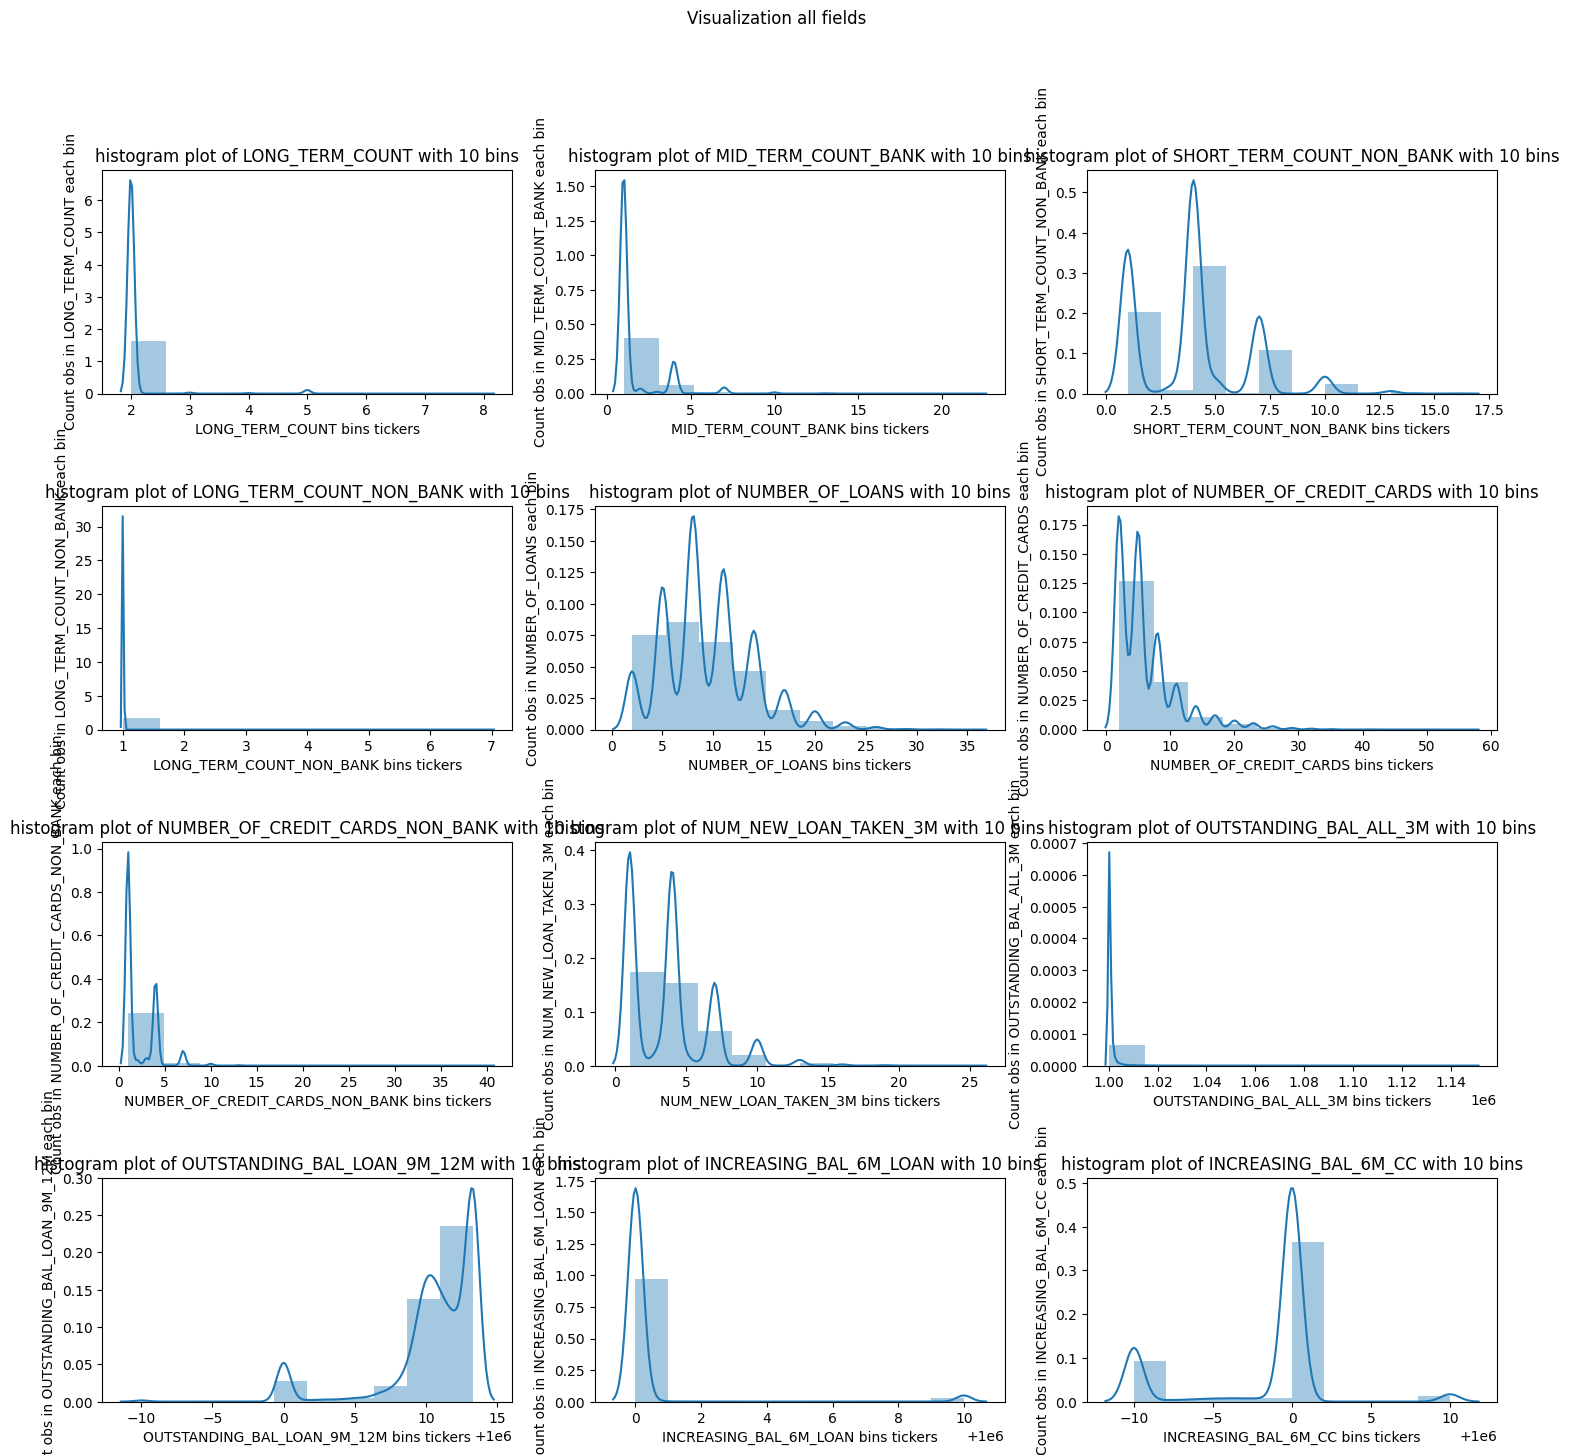

In [1021]:
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(df.columns, df.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(df[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(df[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

In [1022]:
import numpy as np
import matplotlib.pyplot as plt

MAX_VAL = 999999999
MIN_VAL = -MAX_VAL

def bin_table(data, colname, n_bins = 10, coltype = 'int64', qcut = None):
  X = data[[colname, 'label']]
  X = X.sort_values(colname)
  # coltype = X[colname].dtype
  print(coltype)
  if coltype in ['float64', 'int64']:
    if qcut is None:
      try:
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]
  df_GB = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                columns = ['label'],
                aggfunc = {
                    'label':np.size
                })

  df_Count = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                aggfunc = {
                    'label': np.size
                })
  
  if coltype in ['float64', 'int64']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#BAD', '#GOOD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

def WOE(data, colname, n_bins = None, min_obs = 100, coltype='int64', qcut = None):
  # Thống kê bins và lấy ra thres hold ban đầu
  df_summary, thres = bin_table(data, colname, n_bins = n_bins, coltype=coltype, qcut = qcut)
  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})
  
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = bin_table(data, colname, qcut=new_thres)
  
  new_thres = thres
  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

In [1023]:
columns = []
IVs = []
WOE_dict=dict()

In [1024]:
df['LONG_TERM_COUNT'].value_counts()

LONG_TERM_COUNT
2    19533
5      322
3       87
4       48
8       10
Name: count, dtype: int64

In [1025]:
df_summary, IV, thres = WOE(df, 'LONG_TERM_COUNT', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('LONG_TERM_COUNT')
IVs.append(IV)
WOE_dict['LONG_TERM_COUNT'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of LONG_TERM_COUNT column: 0.011099831725829908


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                    
2      19533  15925.0  3608.0  0.226562  0.973649  0.990121  0.016776   
3         87     79.0     8.0  0.101266  0.004830  0.002195 -0.788493   
4         48     48.0     0.0  0.000000  0.002935  0.000000  0.000000   
5        322    294.0    28.0  0.095238  0.017975  0.007684 -0.849862   
8         10     10.0     0.0  0.000000  0.000611  0.000000  0.000000   

            IV           COLUMN  
bins                             
2     0.000276  LONG_TERM_COUNT  
3     0.002077  LONG_TERM_COUNT  
4     0.000000  LONG_TERM_COUNT  
5     0.008746  LONG_TERM_COUNT  
8     0.000000  LONG_TERM_COUNT

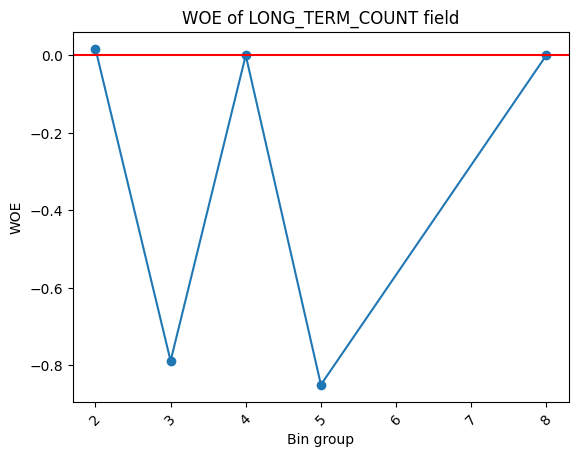

In [1026]:
def _plot(df_summary):
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WOE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')

_plot(df_summary) 

In [1027]:
df_summary, IV, thres = WOE(df, 'MID_TERM_COUNT_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('MID_TERM_COUNT_BANK')
IVs.append(IV)
WOE_dict['MID_TERM_COUNT_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of MID_TERM_COUNT_BANK column: 0.09677078394628191


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                    
1      16452  13138.0  3314.0  0.252245  0.803253  0.909440  0.124160   
2        372    323.0    49.0  0.151703  0.019748  0.013447 -0.384319   
3        134    120.0    14.0  0.116667  0.007337  0.003842 -0.646922   
4       2431   2201.0   230.0  0.104498  0.134568  0.063117 -0.757075   
5         26     26.0     0.0  0.000000  0.001590  0.000000  0.000000   
7        468    437.0    31.0  0.070938  0.026718  0.008507 -1.144433   
10        90     84.0     6.0  0.071429  0.005136  0.001647 -1.137545   
13        21     21.0     0.0  0.000000  0.001284  0.000000  0.000000   
16         5      5.0     0.0  0.000000  0.000306  0.000000  0.000000   
22         1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   

            IV               COLUMN  
bins                                 
1     0.013184  MID_TERM_COUNT_BANK  
2     0.002422  MID_TERM_COUNT_BANK  
3     0.002261  MID_TERM_COUNT_BANK  
4     0.054094  MID_TERM_COUNT_BANK  
5     0.000000  MID_TERM_COUNT_BANK  
7     0.020841  MID_TERM_COUNT_BANK  
10    0.003969  MID_TERM_COUNT_BANK  
13    0.000000  MID_TERM_COUNT_BANK  
16    0.000000  MID_TERM_COUNT_BANK  
22    0.000000  MID_TERM_COUNT_BANK

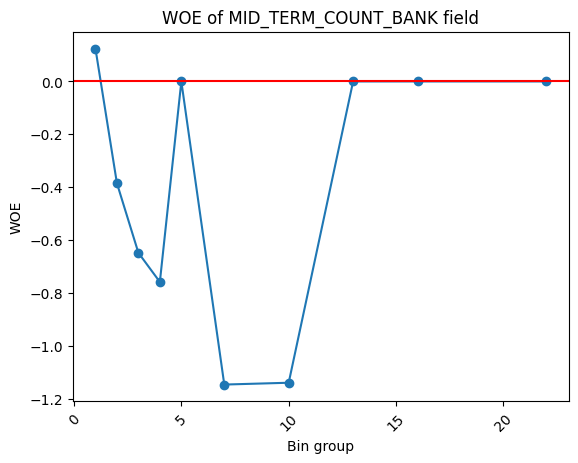

In [1028]:
_plot(df_summary) 

In [1029]:
df_summary, IV, thres = WOE(df, 'SHORT_TERM_COUNT_NON_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('SHORT_TERM_COUNT_NON_BANK')
IVs.append(IV)
WOE_dict['SHORT_TERM_COUNT_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of SHORT_TERM_COUNT_NON_BANK column: 0.4760874968511582


No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD     %GOOD       WOE        IV  \
bins                                                                          
1       6053  4010   2043  0.509476  0.245170  0.560648  0.827141  0.260944   
2         66    38     28  0.736842  0.002323  0.007684  1.196131  0.006412   
3        277   211     66  0.312796  0.012900  0.018112  0.339309  0.001768   
4       8962  7865   1097  0.139479  0.480863  0.301043 -0.468331  0.084215   
5        554   500     54  0.108000  0.030570  0.014819 -0.724111  0.011405   
6         20    17      3  0.176471  0.001039  0.000823 -0.233088  0.000050   
7       3245  2968    277  0.093329  0.181462  0.076015 -0.870113  0.091751   
10       711   646     65  0.100619  0.039496  0.017838 -0.794899  0.017216   
13       105    95     10  0.105263  0.005808  0.002744 -0.749779  0.002297   
16         7     6      1  0.166667  0.000367  0.000274 -0.290247  0.000027   

                         COLUMN  
bins                             
1     SHORT_TERM_COUNT_NON_BANK  
2     SHORT_TERM_COUNT_NON_BANK  
3     SHORT_TERM_COUNT_NON_BANK  
4     SHORT_TERM_COUNT_NON_BANK  
5     SHORT_TERM_COUNT_NON_BANK  
6     SHORT_TERM_COUNT_NON_BANK  
7     SHORT_TERM_COUNT_NON_BANK  
10    SHORT_TERM_COUNT_NON_BANK  
13    SHORT_TERM_COUNT_NON_BANK  
16    SHORT_TERM_COUNT_NON_BANK

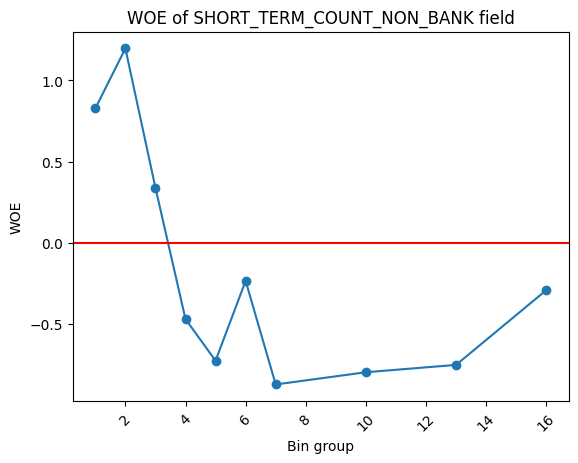

In [1030]:
_plot(df_summary)

In [1031]:
df_summary, IV, thres = WOE(df, 'LONG_TERM_COUNT_NON_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('LONG_TERM_COUNT_NON_BANK')
IVs.append(IV)
WOE_dict['LONG_TERM_COUNT_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of LONG_TERM_COUNT_NON_BANK column: 6.319826417935405e-07


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD  %GOOD       WOE  \
bins                                                                 
1      19987  16343.0  3644.0   0.22297  0.999205    1.0  0.000795   
4         12     12.0     0.0   0.00000  0.000734    0.0  0.000000   
7          1      1.0     0.0   0.00000  0.000061    0.0  0.000000   

                IV                    COLUMN  
bins                                          
1     6.319826e-07  LONG_TERM_COUNT_NON_BANK  
4     0.000000e+00  LONG_TERM_COUNT_NON_BANK  
7     0.000000e+00  LONG_TERM_COUNT_NON_BANK

In [1032]:
df_summary, IV, thres = WOE(df, 'NUMBER_OF_LOANS', n_bins = 4, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_LOANS')
IVs.append(IV)
WOE_dict['NUMBER_OF_LOANS'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of NUMBER_OF_LOANS column: 0.8175897201647706


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
bins                                                                        
(-999999999.0, 6.0]          6.0    5165  3000   2165  0.721667  0.183419   
(6.0, 8.0]                   8.0    5444  4773    671  0.140582  0.291820   
(8.0, 11.0]                 11.0    4610  4120    490  0.118932  0.251895   
(11.0, 999999999.0]  999999999.0    4781  4463    318  0.071253  0.272866   

                        %GOOD       WOE        IV           COLUMN  
bins                                                                
(-999999999.0, 6.0]  0.594127  1.175321  0.482714  NUMBER_OF_LOANS  
(6.0, 8.0]           0.184138 -0.460448  0.049582  NUMBER_OF_LOANS  
(8.0, 11.0]          0.134468 -0.627690  0.073708  NUMBER_OF_LOANS  
(11.0, 999999999.0]  0.087267 -1.140012  0.211586  NUMBER_OF_LOANS

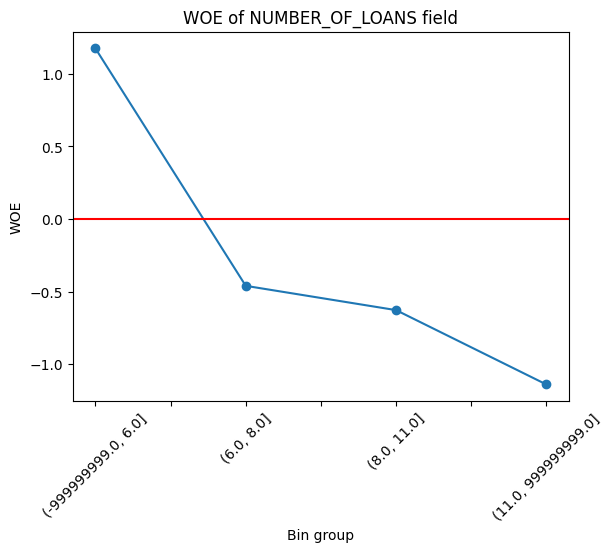

In [1033]:
_plot(df_summary)

In [1034]:
df_summary, IV, thres = WOE(df, 'NUMBER_OF_CREDIT_CARDS', n_bins = 3, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_CREDIT_CARDS')
IVs.append(IV)
WOE_dict['NUMBER_OF_CREDIT_CARDS'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of NUMBER_OF_CREDIT_CARDS column: 0.4471434061368673


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
bins                                                                        
(-999999999.0, 3.0]          3.0    6935  4786   2149  0.449018  0.292614   
(3.0, 7.0]                   7.0    6720  5711   1009  0.176677  0.349169   
(7.0, 999999999.0]   999999999.0    6345  5859    486  0.082949  0.358217   

                        %GOOD       WOE        IV                  COLUMN  
bins                                                                       
(-999999999.0, 3.0]  0.589737  0.700820  0.208229  NUMBER_OF_CREDIT_CARDS  
(3.0, 7.0]           0.276894 -0.231922  0.016762  NUMBER_OF_CREDIT_CARDS  
(7.0, 999999999.0]   0.133370 -0.988013  0.222152  NUMBER_OF_CREDIT_CARDS

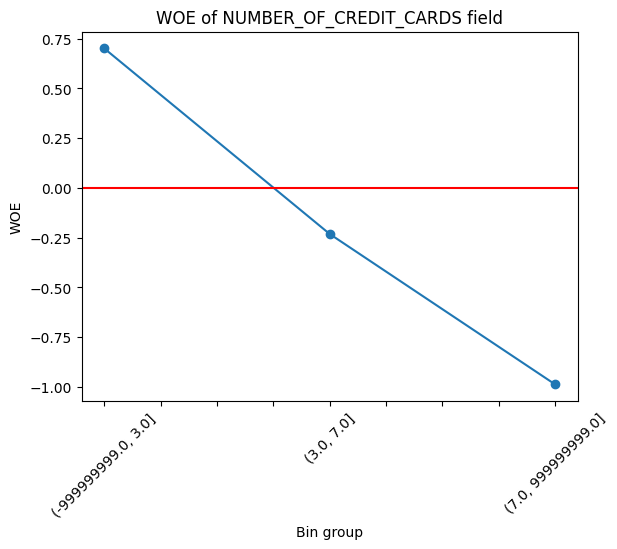

In [1035]:
_plot(df_summary)

In [1036]:
df_summary, IV, thres = WOE(df, 'NUMBER_OF_CREDIT_CARDS_NON_BANK', n_bins = 2, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_CREDIT_CARDS_NON_BANK')
IVs.append(IV)
WOE_dict['NUMBER_OF_CREDIT_CARDS_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of NUMBER_OF_CREDIT_CARDS_NON_BANK column: 0.05824511907199123


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                    
1      12945  10285.0  2660.0  0.258629  0.628821  0.729967  0.149152   
2        333    291.0    42.0  0.144330  0.017792  0.011526 -0.434141   
3        451    419.0    32.0  0.076372  0.025618  0.008782 -1.070622   
4       5222   4462.0   760.0  0.170327  0.272805  0.208562 -0.268521   
5          7      0.0     7.0  0.000000  0.000000  0.001921  0.000000   
7        893    769.0   124.0  0.161248  0.047016  0.034029 -0.323297   
10       112     95.0    17.0  0.178947  0.005808  0.004665 -0.219151   
13        24     22.0     2.0  0.090909  0.001345  0.000549 -0.896382   
16         6      6.0     0.0  0.000000  0.000367  0.000000  0.000000   
19         3      3.0     0.0  0.000000  0.000183  0.000000  0.000000   
22         2      2.0     0.0  0.000000  0.000122  0.000000  0.000000   
34         1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
40         1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   

            IV                           COLUMN  
bins                                             
1     0.015086  NUMBER_OF_CREDIT_CARDS_NON_BANK  
2     0.002720  NUMBER_OF_CREDIT_CARDS_NON_BANK  
3     0.018025  NUMBER_OF_CREDIT_CARDS_NON_BANK  
4     0.017251  NUMBER_OF_CREDIT_CARDS_NON_BANK  
5     0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK  
7     0.004199  NUMBER_OF_CREDIT_CARDS_NON_BANK  
10    0.000251  NUMBER_OF_CREDIT_CARDS_NON_BANK  
13    0.000714  NUMBER_OF_CREDIT_CARDS_NON_BANK  
16    0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK  
19    0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK  
22    0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK  
34    0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK  
40    0.000000  NUMBER_OF_CREDIT_CARDS_NON_BANK

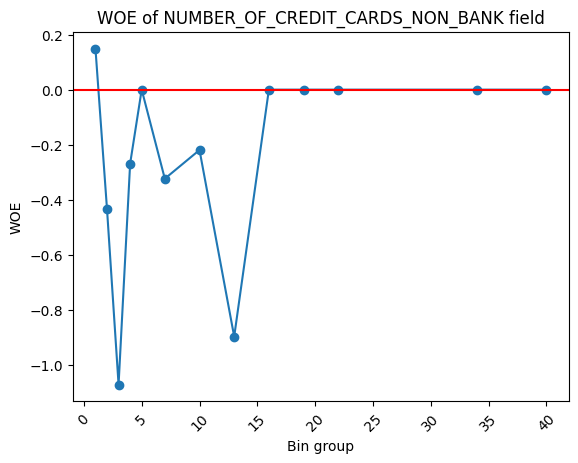

In [1037]:
_plot(df_summary)

In [1038]:
df_summary, IV, thres = WOE(df, 'NUM_NEW_LOAN_TAKEN_3M', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('NUM_NEW_LOAN_TAKEN_3M')
IVs.append(IV)
WOE_dict['NUM_NEW_LOAN_TAKEN_3M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of NUM_NEW_LOAN_TAKEN_3M column: 0.3337521607764823


No_Obs    #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                   
1       7695  5459.0  2236.0  0.409599  0.333761  0.613611  0.608936   
2        191   146.0    45.0  0.308219  0.008926  0.012349  0.324569   
3        488   422.0    66.0  0.156398  0.025801  0.018112 -0.353838   
4       7021  6219.0   802.0  0.128960  0.380227  0.220088 -0.546743   
5        310   268.0    42.0  0.156716  0.016385  0.011526 -0.351805   
6        110    98.0    12.0  0.122449  0.005992  0.003293 -0.598548   
7       2980  2663.0   317.0  0.119039  0.162815  0.086992 -0.626794   
10       941   843.0    98.0  0.116251  0.051541  0.026894 -0.650487   
13       204   183.0    21.0  0.114754  0.011189  0.005763 -0.663451   
16        42    38.0     4.0  0.105263  0.002323  0.001098 -0.749779   
19        14    13.0     1.0  0.076923  0.000795  0.000274 -1.063437   
22         2     2.0     0.0  0.000000  0.000122  0.000000  0.000000   
25         2     2.0     0.0  0.000000  0.000122  0.000000  0.000000   

            IV                 COLUMN  
bins                                   
1     0.170411  NUM_NEW_LOAN_TAKEN_3M  
2     0.001111  NUM_NEW_LOAN_TAKEN_3M  
3     0.002721  NUM_NEW_LOAN_TAKEN_3M  
4     0.087555  NUM_NEW_LOAN_TAKEN_3M  
5     0.001710  NUM_NEW_LOAN_TAKEN_3M  
6     0.001615  NUM_NEW_LOAN_TAKEN_3M  
7     0.047525  NUM_NEW_LOAN_TAKEN_3M  
10    0.016033  NUM_NEW_LOAN_TAKEN_3M  
13    0.003600  NUM_NEW_LOAN_TAKEN_3M  
16    0.000919  NUM_NEW_LOAN_TAKEN_3M  
19    0.000553  NUM_NEW_LOAN_TAKEN_3M  
22    0.000000  NUM_NEW_LOAN_TAKEN_3M  
25    0.000000  NUM_NEW_LOAN_TAKEN_3M

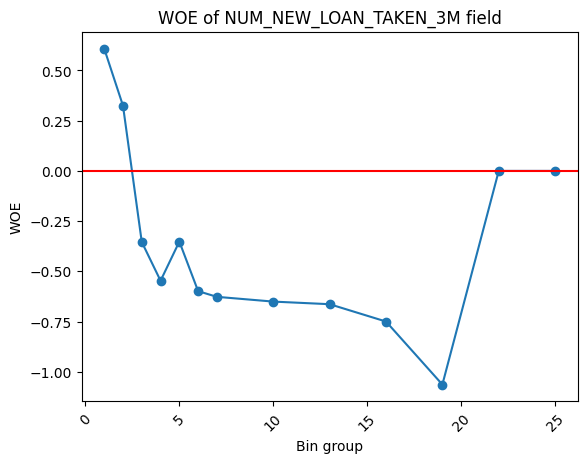

In [1039]:
_plot(df_summary)

In [1040]:
df_summary, IV, thres = WOE(df, 'OUTSTANDING_BAL_ALL_3M', n_bins = 10, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('OUTSTANDING_BAL_ALL_3M')
IVs.append(IV)
WOE_dict['OUTSTANDING_BAL_ALL_3M'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of OUTSTANDING_BAL_ALL_3M column: 1.0520754560023577


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD  \
bins                                                                       
(-999999999.0, 1000016.667]  1.000017e+06    2105   651   1454  2.233487   
(1000016.667, 1000050.0]     1.000050e+06    1916  1601    315  0.196752   
(1000050.0, 1000090.0]       1.000090e+06    2055  1779    276  0.155143   
(1000090.0, 1000143.333]     1.000143e+06    1939  1676    263  0.156921   
(1000143.333, 1000220.0]     1.000220e+06    2038  1760    278  0.157955   
(1000220.0, 1000333.333]     1.000333e+06    1949  1691    258  0.152572   
(1000333.333, 1000506.667]   1.000507e+06    2001  1741    260  0.149339   
(1000506.667, 1000793.333]   1.000793e+06    2003  1775    228  0.128451   
(1000793.333, 1001423.333]   1.001423e+06    1995  1820    175  0.096154   
(1001423.333, 999999999.0]   1.000000e+09    1999  1862    137  0.073577   

                                 %BAD     %GOOD       WOE        IV  \
bins                                                                  
(-999999999.0, 1000016.667]  0.039802  0.399012  2.305077  0.828007   
(1000016.667, 1000050.0]     0.097885  0.086443 -0.124298  0.001422   
(1000050.0, 1000090.0]       0.108767  0.075741 -0.361893  0.011952   
(1000090.0, 1000143.333]     0.102470  0.072173 -0.350498  0.010619   
(1000143.333, 1000220.0]     0.107606  0.076290 -0.343935  0.010771   
(1000220.0, 1000333.333]     0.103387  0.070801 -0.378603  0.012337   
(1000333.333, 1000506.667]   0.106444  0.071350 -0.400020  0.014038   
(1000506.667, 1000793.333]   0.108523  0.062569 -0.550697  0.025307   
(1000793.333, 1001423.333]   0.111274  0.048024 -0.840293  0.053149   
(1001423.333, 999999999.0]   0.113842  0.037596 -1.107913  0.084474   

                                             COLUMN  
bins                                                 
(-999999999.0, 1000016.667]  OUTSTANDING_BAL_ALL_3M  
(1000016.667, 1000050.0]     OUTSTANDING_BAL_ALL_3M  
(1000050.0, 1000090.0]       OUTSTANDING_BAL_ALL_3M  
(1000090.0, 1000143.333]     OUTSTANDING_BAL_ALL_3M  
(1000143.333, 1000220.0]     OUTSTANDING_BAL_ALL_3M  
(1000220.0, 1000333.333]     OUTSTANDING_BAL_ALL_3M  
(1000333.333, 1000506.667]   OUTSTANDING_BAL_ALL_3M  
(1000506.667, 1000793.333]   OUTSTANDING_BAL_ALL_3M  
(1000793.333, 1001423.333]   OUTSTANDING_BAL_ALL_3M  
(1001423.333, 999999999.0]   OUTSTANDING_BAL_ALL_3M

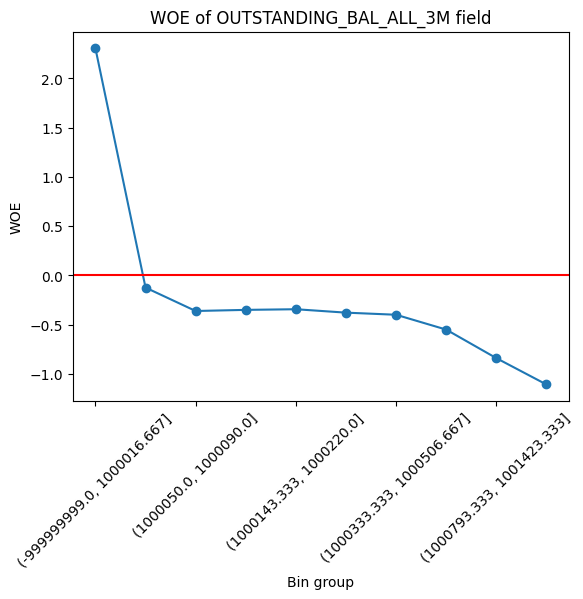

In [1041]:
_plot(df_summary)

In [1042]:
df_summary, IV, thres = WOE(df, 'OUTSTANDING_BAL_LOAN_9M_12M', n_bins = 3, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('OUTSTANDING_BAL_LOAN_9M_12M')
IVs.append(IV)
WOE_dict['OUTSTANDING_BAL_LOAN_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

int64


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,


Information Value of OUTSTANDING_BAL_LOAN_9M_12M column: 0.31762732832563656


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD  \
bins                                                                       
(-999999999.0, 1000010.295]  1.000010e+06    6667  4719   1948  0.412799   
(1000010.295, 1000012.8]     1.000013e+06    6667  6055    612  0.101073   
(1000012.8, 999999999.0]     1.000000e+09    6666  5582   1084  0.194196   

                                 %BAD     %GOOD       WOE        IV  \
bins                                                                  
(-999999999.0, 1000010.295]  0.288518  0.534577  0.616719  0.151750   
(1000010.295, 1000012.8]     0.370201  0.167947 -0.790395  0.159860   
(1000012.8, 999999999.0]     0.341281  0.297475 -0.137376  0.006018   

                                                  COLUMN  
bins                                                      
(-999999999.0, 1000010.295]  OUTSTANDING_BAL_LOAN_9M_12M  
(1000010.295, 1000012.8]     OUTSTANDING_BAL_LOAN_9M_12M  
(1000012.8, 999999999.0]     OUTSTANDING_BAL_LOAN_9M_12M

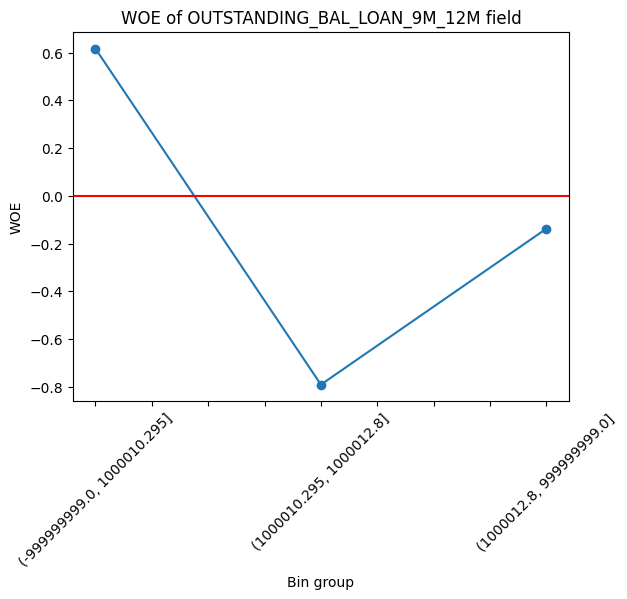

In [1043]:
_plot(df_summary)

In [1044]:
df_summary, IV, thres = WOE(df, 'INCREASING_BAL_6M_LOAN', n_bins = 5, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_6M_LOAN')
IVs.append(IV)
WOE_dict['INCREASING_BAL_6M_LOAN'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of INCREASING_BAL_6M_LOAN column: 0.2513598802953644


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                            
1.000000e+06   18401  15309.0  3092.0  0.201973  0.935987  0.848518 -0.098110   
1.000000e+06     386    386.0     0.0  0.000000  0.023600  0.000000  0.000000   
1.000000e+06     222    222.0     0.0  0.000000  0.013573  0.000000  0.000000   
1.000000e+06      62      0.0    62.0  0.000000  0.000000  0.017014  0.000000   
1.000000e+06     143    143.0     0.0  0.000000  0.008743  0.000000  0.000000   
1.000000e+06      63     63.0     0.0  0.000000  0.003852  0.000000  0.000000   
1.000000e+06      53      0.0    53.0  0.000000  0.000000  0.014544  0.000000   
1.000000e+06      39     39.0     0.0  0.000000  0.002384  0.000000  0.000000   
1.000000e+06      15     15.0     0.0  0.000000  0.000917  0.000000  0.000000   
1.000000e+06      18      0.0    18.0  0.000000  0.000000  0.004940  0.000000   
1.000001e+06      11     11.0     0.0  0.000000  0.000673  0.000000  0.000000   
1.000001e+06       3      3.0     0.0  0.000000  0.000183  0.000000  0.000000   
1.000001e+06       3      0.0     3.0  0.000000  0.000000  0.000823  0.000000   
1.000001e+06       3      3.0     0.0  0.000000  0.000183  0.000000  0.000000   
1.000001e+06       3      3.0     0.0  0.000000  0.000183  0.000000  0.000000   
1.000001e+06       7      0.0     7.0  0.000000  0.000000  0.001921  0.000000   
1.000001e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000001e+06       2      2.0     0.0  0.000000  0.000122  0.000000  0.000000   
1.000001e+06       1      0.0     1.0  0.000000  0.000000  0.000274  0.000000   
1.000001e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000001e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000001e+06       1      0.0     1.0  0.000000  0.000000  0.000274  0.000000   
1.000001e+06       2      0.0     2.0  0.000000  0.000000  0.000549  0.000000   
1.000002e+06       4      0.0     4.0  0.000000  0.000000  0.001098  0.000000   
1.000002e+06       2      0.0     2.0  0.000000  0.000000  0.000549  0.000000   
1.000002e+06       1      0.0     1.0  0.000000  0.000000  0.000274  0.000000   
1.000002e+06       1      0.0     1.0  0.000000  0.000000  0.000274  0.000000   
1.000003e+06       1      0.0     1.0  0.000000  0.000000  0.000274  0.000000   
1.000010e+06     550    154.0   396.0  2.571429  0.009416  0.108672  2.445974   

                    IV                  COLUMN  
bins                                            
1.000000e+06  0.008582  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000000e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000001e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000002e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000002e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000002e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000002e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000003e+06  0.000000  INCREASING_BAL_6M_LOAN  
1.000010e+06  0.242778  INCREASI

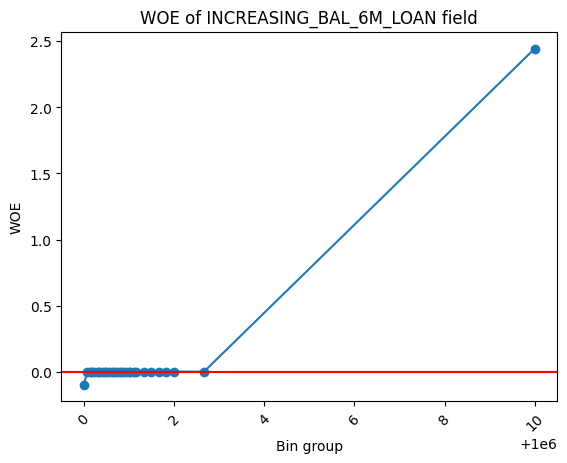

In [1045]:
_plot(df_summary)

In [1046]:
df_summary, IV, thres = WOE(df, 'INCREASING_BAL_6M_CC', n_bins = 2, min_obs= 500, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_6M_CC')
IVs.append(IV)
WOE_dict['INCREASING_BAL_6M_CC'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of INCREASING_BAL_6M_CC column: 0.08844529103108699


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs   #BAD  #GOOD  GOOD/BAD  \
bins                                                                     
(-999999999.0, 1000000.0]    1000000.0   18958  15729   3229  0.205290   
(1000000.0, 999999999.0]   999999999.0    1042    627    415  0.661882   

                               %BAD     %GOOD       WOE        IV  \
bins                                                                
(-999999999.0, 1000000.0]  0.961665  0.886114 -0.081821  0.006182   
(1000000.0, 999999999.0]   0.038335  0.113886  1.088845  0.082264   

                                         COLUMN  
bins                                             
(-999999999.0, 1000000.0]  INCREASING_BAL_6M_CC  
(1000000.0, 999999999.0]   INCREASING_BAL_6M_CC

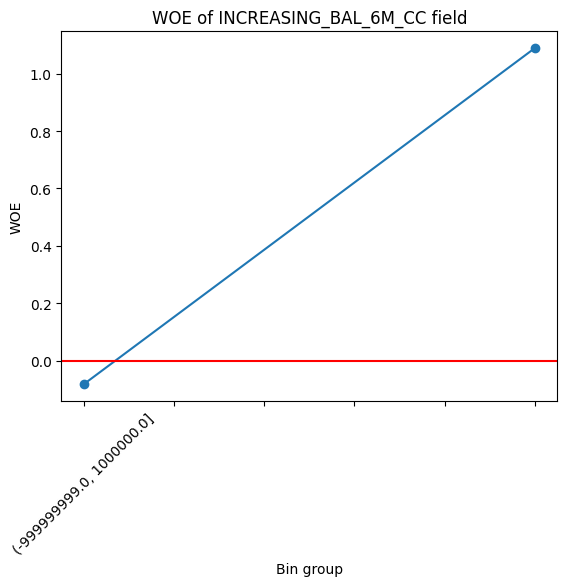

In [1047]:
_plot(df_summary)

In [1048]:
df_summary, IV, thres = WOE(df, 'INCREASING_BAL_3M_ALL', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_3M_ALL')
IVs.append(IV)
WOE_dict['INCREASING_BAL_3M_ALL'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of INCREASING_BAL_3M_ALL column: 0.021382547143203694


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                            
1.000000e+06   15571  12845.0  2726.0  0.212223  0.785339  0.748079 -0.048606   
1.000000e+06      26     26.0     0.0  0.000000  0.001590  0.000000  0.000000   
1.000000e+06      31     31.0     0.0  0.000000  0.001895  0.000000  0.000000   
1.000000e+06      21      0.0    21.0  0.000000  0.000000  0.005763  0.000000   
1.000000e+06      29     29.0     0.0  0.000000  0.001773  0.000000  0.000000   
...              ...      ...     ...       ...       ...       ...       ...   
1.000004e+06       2      2.0     0.0  0.000000  0.000122  0.000000  0.000000   
1.000004e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000004e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000004e+06       1      1.0     0.0  0.000000  0.000061  0.000000  0.000000   
1.000010e+06    2578   1950.0   628.0  0.322051  0.119222  0.172338  0.368468   

                    IV                 COLUMN  
bins                                           
1.000000e+06  0.001811  INCREASING_BAL_3M_ALL  
1.000000e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000000e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000000e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000000e+06  0.000000  INCREASING_BAL_3M_ALL  
...                ...                    ...  
1.000004e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000004e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000004e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000004e+06  0.000000  INCREASING_BAL_3M_ALL  
1.000010e+06  0.019571  INCREASING_BAL_3M_ALL  

[67 rows x 9 columns]

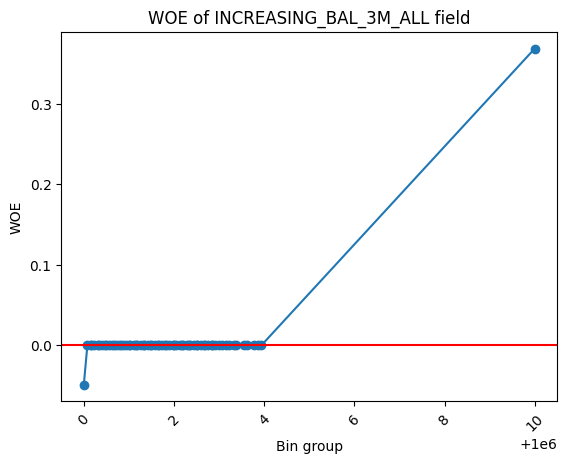

In [1049]:
_plot(df_summary)

In [1050]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M', n_bins = 3, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M column: 0.03719963343936678


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
bins                                                                        
(-999999999.0, 7.0]          7.0    8724  6858   1866  0.272091  0.419296   
(7.0, 12.0]                 12.0    7501  6367   1134  0.178106  0.389276   
(12.0, 999999999.0]  999999999.0    3775  3131    644  0.205685  0.191428   

                        %GOOD       WOE        IV  \
bins                                                
(-999999999.0, 7.0]  0.512075  0.199894  0.018546   
(7.0, 12.0]          0.311196 -0.223864  0.017479   
(12.0, 999999999.0]  0.176729 -0.079896  0.001174   

                                                  COLUMN  
bins                                                      
(-999999999.0, 7.0]  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M  
(7.0, 12.0]          ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M  
(12.0, 999999999.0]  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M

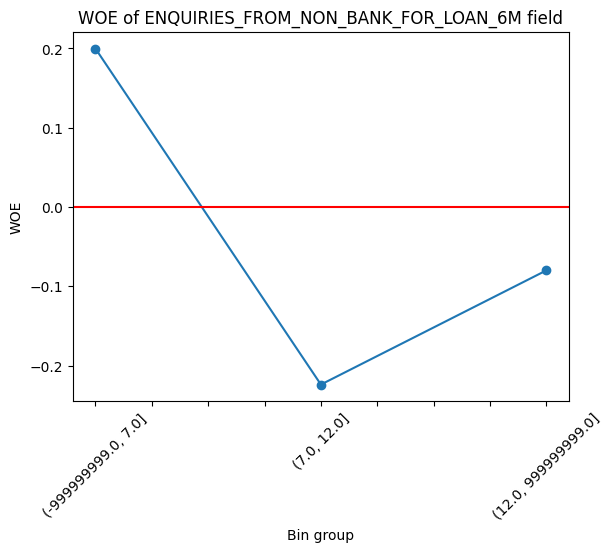

In [1051]:
_plot(df_summary)

In [1052]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_FOR_LOAN_12M', n_bins = 5, min_obs= 100, coltype='int64')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FOR_LOAN_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FOR_LOAN_12M'] = {'table':df_summary, 'IV':IV}
df_summary

int64
Information Value of ENQUIRIES_FOR_LOAN_12M column: 0.1558135546810421


C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
C:\Users\HP\AppData\Local\Temp\ipykernel_12472\3189362113.py:36: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
bins                                                                        
(-999999999.0, 7.0]          7.0    4916  3598   1318  0.366315  0.219980   
(7.0, 12.0]                 12.0    4562  3712    850  0.228987  0.226950   
(12.0, 17.0]                17.0    3137  2570    567  0.220623  0.157129   
(17.0, 27.0]                27.0    3547  3018    529  0.175282  0.184519   
(27.0, 999999999.0]  999999999.0    3838  3458    380  0.109890  0.211421   

                        %GOOD       WOE        IV                  COLUMN  
bins                                                                       
(-999999999.0, 7.0]  0.361690  0.497250  0.070465  ENQUIRIES_FOR_LOAN_12M  
(7.0, 12.0]          0.233260  0.027423  0.000173  ENQUIRIES_FOR_LOAN_12M  
(12.0, 17.0]         0.155598 -0.009789  0.000015  ENQUIRIES_FOR_LOAN_12M  
(17.0, 27.0]         0.145170 -0.239848  0.009438  ENQUIRIES_FOR_LOAN_12M  
(27.0, 999999999.0]  0.104281 -0.706762  0.075722  ENQUIRIES_FOR_LOAN_12M

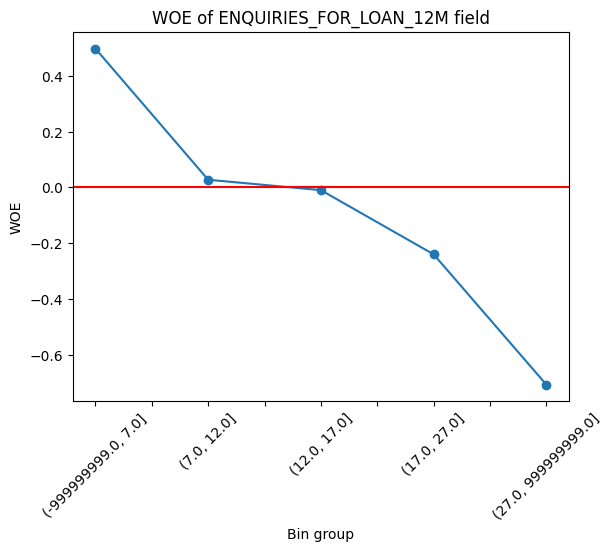

In [1053]:
_plot(df_summary)

In [1054]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M', n_bins = 2, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_FOR_CC_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_FOR_CC_12M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_CC_12M column: 0.007817619350137564


No_Obs     #BAD   #GOOD  GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                    
2      16743  13653.0  3090.0  0.226324  0.834740  0.847969  0.015725   
3        458    370.0    88.0  0.237838  0.022622  0.024149  0.065347   
4        346    309.0    37.0  0.119741  0.018892  0.010154 -0.620911   
5        110     93.0    17.0  0.182796  0.005686  0.004665 -0.197873   
6          5      0.0     5.0  0.000000  0.000000  0.001372  0.000000   
7       1664   1363.0   301.0  0.220836  0.083333  0.082602 -0.008820   
12       469    389.0    80.0  0.205656  0.023783  0.021954 -0.080040   
17       130    114.0    16.0  0.140351  0.006970  0.004391 -0.462097   
22        43     36.0     7.0  0.194444  0.002201  0.001921 -0.136096   
27        12     11.0     1.0  0.090909  0.000673  0.000274 -0.896382   
32         6      6.0     0.0  0.000000  0.000367  0.000000  0.000000   
37         7      5.0     2.0  0.400000  0.000306  0.000549  0.585222   
42         3      3.0     0.0  0.000000  0.000183  0.000000  0.000000   
47         2      2.0     0.0  0.000000  0.000122  0.000000  0.000000   
52         2      2.0     0.0  0.000000  0.000122  0.000000  0.000000   

            IV                              COLUMN  
bins                                                
2     0.000208  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
3     0.000100  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
4     0.005426  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
5     0.000202  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
6     0.000000  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
7     0.000006  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
12    0.000146  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
17    0.001192  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
22    0.000038  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
27    0.000357  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
32    0.000000  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
37    0.000142  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
42    0.000000  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
47    0.000000  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  
52    0.000000  ENQUIRIES_FROM_NON_BANK_FOR_CC_12M

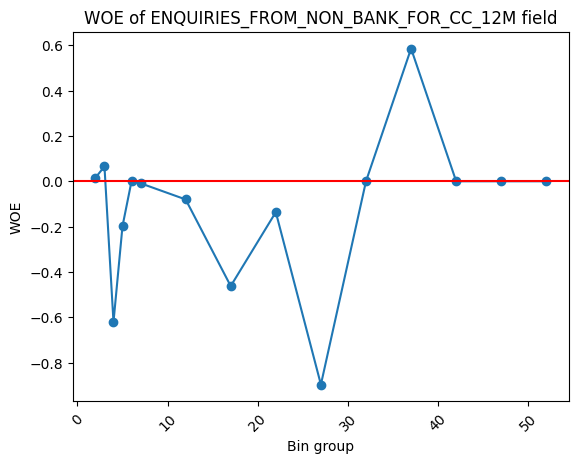

In [1055]:
_plot(df_summary)

In [1056]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_6M_9M', n_bins = 2, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_6M_9M')
IVs.append(IV)
WOE_dict['ENQUIRIES_6M_9M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of ENQUIRIES_6M_9M column: 0.6738618828918407


No_Obs   #BAD  #GOOD   GOOD/BAD      %BAD     %GOOD       WOE        IV  \
bins                                                                            
2        351      4    347  86.750000  0.000245  0.095225  5.964543  0.566515   
3        376    337     39   0.115727  0.020604  0.010703 -0.655008  0.006486   
4        735    662     73   0.110272  0.040474  0.020033 -0.703293  0.014376   
5       2137   1923    214   0.111284  0.117572  0.058727 -0.694153  0.040847   
6       2368   2123    245   0.115403  0.129799  0.067234 -0.657814  0.041157   
7      14033  11307   2726   0.241090  0.691306  0.748079  0.078926  0.004481   

               COLUMN  
bins                   
2     ENQUIRIES_6M_9M  
3     ENQUIRIES_6M_9M  
4     ENQUIRIES_6M_9M  
5     ENQUIRIES_6M_9M  
6     ENQUIRIES_6M_9M  
7     ENQUIRIES_6M_9M

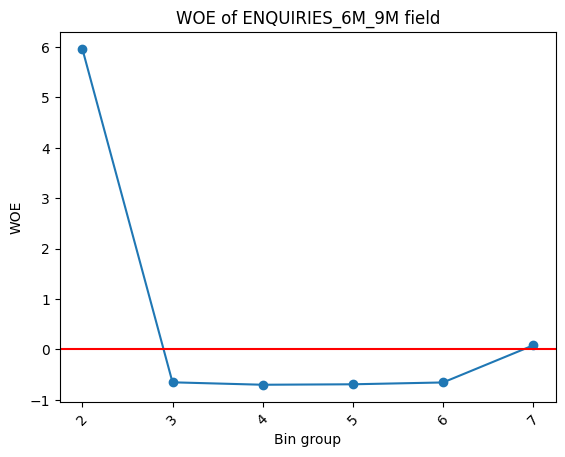

In [1057]:
_plot(df_summary)

In [1058]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_9M_12M', n_bins = 2, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_9M_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of ENQUIRIES_9M_12M column: 0.6796533645607746


No_Obs   #BAD  #GOOD    GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                   
2        351      3    348  116.000000  0.000183  0.095499  6.255103   
3        167    151     16    0.105960  0.009232  0.004391 -0.743178   
4        462    416     46    0.110577  0.025434  0.012623 -0.700531   
5       1536   1345    191    0.142007  0.082233  0.052415 -0.450363   
6       2402   2180    222    0.101835  0.133284  0.060922 -0.782890   
7      15082  12261   2821    0.230079  0.749633  0.774149  0.032181   

            IV            COLUMN  
bins                              
2     0.596212  ENQUIRIES_9M_12M  
3     0.003598  ENQUIRIES_9M_12M  
4     0.008974  ENQUIRIES_9M_12M  
5     0.013429  ENQUIRIES_9M_12M  
6     0.056652  ENQUIRIES_9M_12M  
7     0.000789  ENQUIRIES_9M_12M

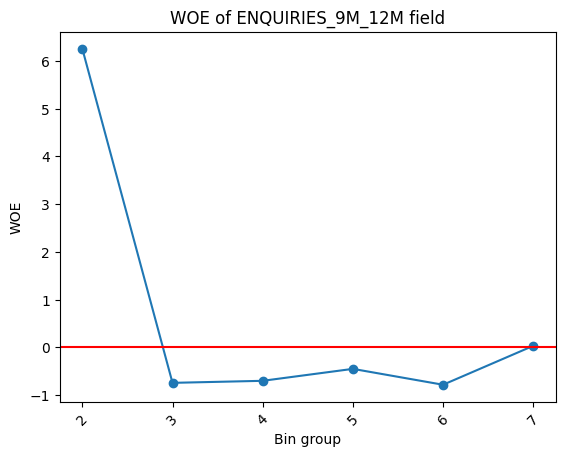

In [1059]:
_plot(df_summary)

In [1060]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_BANK_9M_12M', n_bins = 4, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_BANK_9M_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_BANK_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of ENQUIRIES_FROM_BANK_9M_12M column: 0.6527881909358946


No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD     %GOOD       WOE        IV  \
bins                                                                          
2       3482  1869   1613  0.863028  0.114270  0.442645  1.354205  0.444688   
3       7615  6846    769  0.112328  0.418562  0.211032 -0.684816  0.142120   
4        957   832    125  0.150240  0.050868  0.034303 -0.394006  0.006527   
5       1580  1426    154  0.107994  0.087185  0.042261 -0.724163  0.032532   
6        757   694     63  0.090778  0.042431  0.017289 -0.897824  0.022573   
7       5609  4689    920  0.196204  0.286684  0.252470 -0.127088  0.004348   

                          COLUMN  
bins                              
2     ENQUIRIES_FROM_BANK_9M_12M  
3     ENQUIRIES_FROM_BANK_9M_12M  
4     ENQUIRIES_FROM_BANK_9M_12M  
5     ENQUIRIES_FROM_BANK_9M_12M  
6     ENQUIRIES_FROM_BANK_9M_12M  
7     ENQUIRIES_FROM_BANK_9M_12M

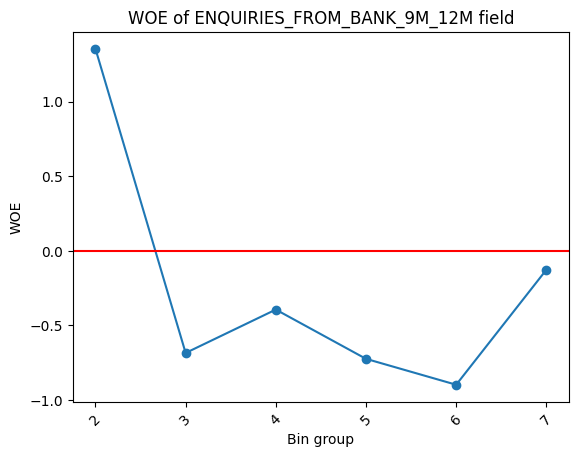

In [1061]:
_plot(df_summary)

In [1062]:
df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_3M_6M', n_bins = 2, min_obs= 100, coltype='object')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_3M_6M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_3M_6M'] = {'table':df_summary, 'IV':IV}
df_summary

object
Information Value of ENQUIRIES_FROM_NON_BANK_3M_6M column: 0.7502943172143777


No_Obs   #BAD  #GOOD    GOOD/BAD      %BAD     %GOOD       WOE  \
bins                                                                   
2        348      1    347  347.000000  0.000061  0.095225  7.350838   
3        196    166     30    0.180723  0.010149  0.008233 -0.209278   
4        607    547     60    0.109689  0.033443  0.016465 -0.708591   
5       2322   2047    275    0.134343  0.125153  0.075467 -0.505847   
6       1162   1026    136    0.132554  0.062729  0.037322 -0.519255   
7      15365  12569   2796    0.222452  0.768464  0.767289 -0.001531   

            IV                         COLUMN  
bins                                           
2     0.699534  ENQUIRIES_FROM_NON_BANK_3M_6M  
3     0.000401  ENQUIRIES_FROM_NON_BANK_3M_6M  
4     0.012030  ENQUIRIES_FROM_NON_BANK_3M_6M  
5     0.025134  ENQUIRIES_FROM_NON_BANK_3M_6M  
6     0.013193  ENQUIRIES_FROM_NON_BANK_3M_6M  
7     0.000002  ENQUIRIES_FROM_NON_BANK_3M_6M

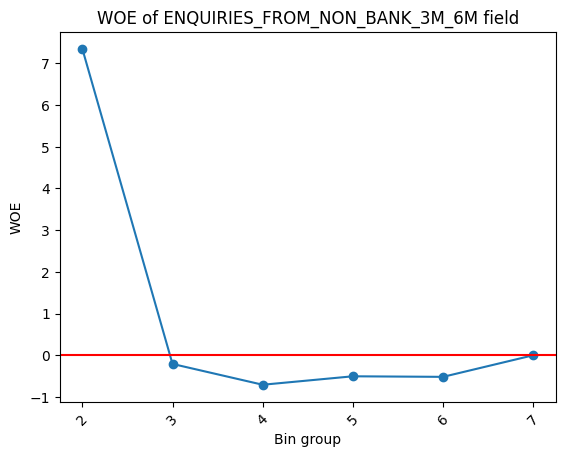

In [1063]:
_plot(df_summary)

In [1064]:
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})
def _rank_IV(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)

column            IV        rank
8                OUTSTANDING_BAL_ALL_3M  1.052075e+00  suspicious
4                       NUMBER_OF_LOANS  8.175897e-01  suspicious
19        ENQUIRIES_FROM_NON_BANK_3M_6M  7.502943e-01  suspicious
17                     ENQUIRIES_9M_12M  6.796534e-01  suspicious
16                      ENQUIRIES_6M_9M  6.738619e-01  suspicious
18           ENQUIRIES_FROM_BANK_9M_12M  6.527882e-01  suspicious
2             SHORT_TERM_COUNT_NON_BANK  4.760875e-01      Strong
5                NUMBER_OF_CREDIT_CARDS  4.471434e-01      Strong
7                 NUM_NEW_LOAN_TAKEN_3M  3.337522e-01      Strong
9           OUTSTANDING_BAL_LOAN_9M_12M  3.176273e-01      Strong
10               INCREASING_BAL_6M_LOAN  2.513599e-01      Medium
14               ENQUIRIES_FOR_LOAN_12M  1.558136e-01      Medium
1                   MID_TERM_COUNT_BANK  9.677078e-02        Weak
11                 INCREASING_BAL_6M_CC  8.844529e-02        Weak
6       NUMBER_OF_CREDIT_CARDS_NON_BANK  5.824512e-02        Weak
13  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M  3.719963e-02        Weak
12                INCREASING_BAL_3M_ALL  2.138255e-02        Weak
0                       LONG_TERM_COUNT  1.109983e-02     Useless
15   ENQUIRIES_FROM_NON_BANK_FOR_CC_12M  7.817619e-03     Useless
3              LONG_TERM_COUNT_NON_BANK  6.319826e-07     Useless

In [1065]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    df[col_woe] = df[col].map(d)
  except:
    print(col)

In [1066]:
# drop_cols = df_WOE[df_WOE['rank']=='Useless']['column'].values
# df.drop(drop_cols, axis=1, inplace=True)

# for col in drop_cols:
#     if col in columns:
#         columns.remove(col)

In [1067]:
df.head()

LONG_TERM_COUNT  MID_TERM_COUNT_BANK  SHORT_TERM_COUNT_NON_BANK  \
customer_id                                                                    
0                          2                    1                          4   
2                          2                    1                          7   
3                          2                    1                         10   
4                          2                    1                          4   
6                          2                    1                          1   

             LONG_TERM_COUNT_NON_BANK  NUMBER_OF_LOANS  \
customer_id                                              
0                                   1                5   
2                                   1               11   
3                                   1               11   
4                                   1                8   
6                                   1                2   

             NUMBER_OF_CREDIT_CARDS  NUMBER_OF_CREDIT_CARDS_NON_BANK  \
customer_id                                                            
0                                 2                                1   
2                                 2                                1   
3                                 3                                1   
4                                 5                                4   
6                                 2                                1   

             NUM_NEW_LOAN_TAKEN_3M  OUTSTANDING_BAL_ALL_3M  \
customer_id                                                  
0                                4            1.000025e+06   
2                                4            1.000087e+06   
3                                3            1.000163e+06   
4                                1            1.000263e+06   
6                                1            1.000000e+06   

             OUTSTANDING_BAL_LOAN_9M_12M  ...  INCREASING_BAL_6M_LOAN_WOE  \
customer_id                               ...                               
0                           1.000013e+06  ...                   -0.098110   
2                           1.000013e+06  ...                   -0.098110   
3                           1.000012e+06  ...                   -0.098110   
4                           1.000011e+06  ...                   -0.098110   
6                           1.000000e+06  ...                    2.445974   

             INCREASING_BAL_6M_CC_WOE  INCREASING_BAL_3M_ALL_WOE  \
customer_id                                                        
0                           -0.081821                  -0.048606   
2                           -0.081821                  -0.048606   
3                           -0.081821                  -0.048606   
4                           -0.081821                   0.368468   
6                            1.088845                   0.368468   

             ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M_WOE  \
customer_id                                            
0                                           0.199894   
2                                           0.199894   
3                                           0.199894   
4                                          -0.079896   
6                                           0.199894   

             ENQUIRIES_FOR_LOAN_12M_WOE  \
customer_id                               
0                              0.497250   
2                              0.497250   
3                              0.027423   
4                             -0.706762   
6                              0.497250   

             ENQUIRIES_FROM_NON_BANK_FOR_CC_12M_WOE  ENQUIRIES_6M_9M_WOE  \
customer_id                                                                
0                                          0.015725             0.078926   
2                                          0.015725             0.078926   
3                                          0.015725             0.078926   
4            

In [1068]:
df.isna().sum()

LONG_TERM_COUNT                            0
MID_TERM_COUNT_BANK                        0
SHORT_TERM_COUNT_NON_BANK                  0
LONG_TERM_COUNT_NON_BANK                   0
NUMBER_OF_LOANS                            0
NUMBER_OF_CREDIT_CARDS                     0
NUMBER_OF_CREDIT_CARDS_NON_BANK            0
NUM_NEW_LOAN_TAKEN_3M                      0
OUTSTANDING_BAL_ALL_3M                     0
OUTSTANDING_BAL_LOAN_9M_12M                0
INCREASING_BAL_6M_LOAN                     0
INCREASING_BAL_6M_CC                       0
INCREASING_BAL_3M_ALL                      0
ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M        0
ENQUIRIES_FOR_LOAN_12M                     0
ENQUIRIES_FROM_NON_BANK_FOR_CC_12M         0
ENQUIRIES_6M_9M                            0
ENQUIRIES_9M_12M                           0
ENQUIRIES_FROM_BANK_9M_12M                 0
ENQUIRIES_FROM_NON_BANK_3M_6M              0
label                                      0
LONG_TERM_COUNT_WOE                        0
MID_TERM_C

In [1069]:
X = df.filter(like='_WOE', axis = 1)
y = df['label']

ids = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, ids, test_size = 0.2, stratify = y, shuffle = True, random_state = 123)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (16000, 20)
X_test shape:  (4000, 20)
y_train shape:  (16000,)
y_test shape:  (4000,)


In [1070]:
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=1, penalty='l2')
logit_model.fit(X_train, y_train)
ybar_logistic = logit_model.predict(X_train)
ypred_logistic = logit_model.predict(X_test)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_logistic)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_logistic)*100))
print('AUC: {}'.format(roc_auc_score(y_test, ypred_logistic)))
print('Gini: {}'.format(2*roc_auc_score(y_test, ypred_logistic)-1))

Accuracy for train data: 87.16874999999999%
Accuracy for validation data: 87.55%
AUC: 0.7021432474516252
Gini: 0.4042864949032503


In [1071]:
def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'LONG_TERM_COUNT_WOE': -0.03973295634683802,
 'MID_TERM_COUNT_BANK_WOE': 0.08008730892989291,
 'SHORT_TERM_COUNT_NON_BANK_WOE': 0.3627219860406113,
 'LONG_TERM_COUNT_NON_BANK_WOE': -0.0008964995718640302,
 'NUMBER_OF_LOANS_WOE': 0.2869359105313312,
 'NUMBER_OF_CREDIT_CARDS_WOE': 0.5837664012218807,
 'NUMBER_OF_CREDIT_CARDS_NON_BANK_WOE': -0.8061005915483573,
 'NUM_NEW_LOAN_TAKEN_3M_WOE': 0.22365368683076225,
 'OUTSTANDING_BAL_ALL_3M_WOE': 0.42235053851241977,
 'OUTSTANDING_BAL_LOAN_9M_12M_WOE': 0.36565266435271093,
 'INCREASING_BAL_6M_LOAN_WOE': -0.04563163398661031,
 'INCREASING_BAL_6M_CC_WOE': 0.05891787744562746,
 'INCREASING_BAL_3M_ALL_WOE': 0.2462952186497702,
 'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M_WOE': -0.17880204087459114,
 'ENQUIRIES_FOR_LOAN_12M_WOE': -0.5036498940840292,
 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M_WOE': -0.1191527528456587,
 'ENQUIRIES_6M_9M_WOE': 0.2673821854555154,
 'ENQUIRIES_9M_12M_WOE': 0.42689064473178373,
 'ENQUIRIES_FROM_BANK_9M_12M_WOE': 0.4874986157502536

In [1072]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
      col_woe = col+'_WOE'
      if col_woe not in df.columns:
        continue
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)    
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = X.shape[1])
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE.head()

Columns Features       WOE     Betas     Scores
0  LONG_TERM_COUNT        2  0.016776 -0.039733  30.004576
1  LONG_TERM_COUNT        3 -0.788493 -0.039733  27.696571
2  LONG_TERM_COUNT        4  0.000000 -0.039733  29.956493
3  LONG_TERM_COUNT        5 -0.849862 -0.039733  27.520680
4  LONG_TERM_COUNT        8  0.000000 -0.039733  29.956493

In [1073]:
df_WOE.head(20)

Columns Features       WOE     Betas     Scores
0             LONG_TERM_COUNT        2  0.016776 -0.039733  30.004576
1             LONG_TERM_COUNT        3 -0.788493 -0.039733  27.696571
2             LONG_TERM_COUNT        4  0.000000 -0.039733  29.956493
3             LONG_TERM_COUNT        5 -0.849862 -0.039733  27.520680
4             LONG_TERM_COUNT        8  0.000000 -0.039733  29.956493
5         MID_TERM_COUNT_BANK        1  0.124160  0.080087  29.239212
6         MID_TERM_COUNT_BANK        2 -0.384319  0.080087  32.176735
7         MID_TERM_COUNT_BANK        3 -0.646922  0.080087  33.693810
8         MID_TERM_COUNT_BANK        4 -0.757075  0.080087  34.330174
9         MID_TERM_COUNT_BANK        5  0.000000  0.080087  29.956493
10        MID_TERM_COUNT_BANK        7 -1.144433  0.080087  36.567973
11        MID_TERM_COUNT_BANK       10 -1.137545  0.080087  36.528177
12        MID_TERM_COUNT_BANK       13  0.000000  0.080087  29.956493
13        MID_TERM_COUNT_BANK       16  0.000000  0.080087  29.956493
14        MID_TERM_COUNT_BANK       22  0.000000  0.080087  29.956493
15  SHORT_TERM_COUNT_NON_BANK        1  0.827141  0.362722   8.314467
16  SHORT_TERM_COUNT_NON_BANK        2  1.196131  0.362722  -1.340112
17  SHORT_TERM_COUNT_NON_BANK        3  0.339309  0.362722  21.078509
18  SHORT_TERM_COUNT_NON_BANK        4 -0.468331  0.362722  42.210296
19  SHORT_TERM_COUNT_NON_BANK        5 -0.724111  0.362722  48.902763

In [1074]:
df_WOE[(df_WOE['Columns'] == 'LONG_TERM_COUNT')]

Columns Features       WOE     Betas     Scores
0  LONG_TERM_COUNT        2  0.016776 -0.039733  30.004576
1  LONG_TERM_COUNT        3 -0.788493 -0.039733  27.696571
2  LONG_TERM_COUNT        4  0.000000 -0.039733  29.956493
3  LONG_TERM_COUNT        5 -0.849862 -0.039733  27.520680
4  LONG_TERM_COUNT        8  0.000000 -0.039733  29.956493

In [1075]:
df_WOE[df_WOE['Columns']=='ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M']

Columns             Features       WOE  \
172  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M  (-999999999.0, 7.0]  0.199894   
173  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M          (7.0, 12.0] -0.223864   
174  ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M  (12.0, 999999999.0] -0.079896   

        Betas     Scores  
172 -0.178802  32.534695  
173 -0.178802  27.069126  
174 -0.178802  28.926005

In [1087]:
df_WOE['Left'] = df_WOE['Features'].apply(lambda x: float(x) if x[0].isdigit() else float(x[1:-1].split(',')[0]))
df_WOE['Right'] = df_WOE['Features'].apply(lambda x: float(x) if x[0].isdigit() else float(x[1:-1].split(',')[1]))

In [1117]:
df_WOE[df_WOE['Scores']<0]

Columns                     Features       WOE  \
16         SHORT_TERM_COUNT_NON_BANK                            2  1.196131   
37   NUMBER_OF_CREDIT_CARDS_NON_BANK                            3 -1.070622   
42   NUMBER_OF_CREDIT_CARDS_NON_BANK                           13 -0.896382   
61            OUTSTANDING_BAL_ALL_3M  (-999999999.0, 1000016.667]  2.305077   
195                  ENQUIRIES_6M_9M                            2  5.964543   
201                 ENQUIRIES_9M_12M                            2  6.255103   
207       ENQUIRIES_FROM_BANK_9M_12M                            2  1.354205   
213    ENQUIRIES_FROM_NON_BANK_3M_6M                            2  7.350838   

        Betas      Scores         Left        Right  
16   0.362722   -1.340112          2.0        2.000  
37  -0.806101  -32.297903          3.0        3.000  
42  -0.806101  -22.166234         13.0       13.000  
61   0.422351  -40.270327 -999999999.0  1000016.667  
195  0.267382  -85.084919          2.0        2.000  
201  0.426891 -162.660965          2.0        2.000  
207  0.487499  -17.664930          2.0        2.000  
213  0.243331  -99.069728          2.0        2.000

In [1120]:
df[df['Score']<0][columns]

LONG_TERM_COUNT  MID_TERM_COUNT_BANK  SHORT_TERM_COUNT_NON_BANK  \
customer_id                                                                    
6                          2                    1                          1   
20                         2                    1                          1   
48                         2                    1                          1   
52                         2                    1                          1   
56                         2                    1                          1   
...                      ...                  ...                        ...   
5537                       2                    1                          1   
5562                       2                    1                          1   
5578                       2                    1                          1   
5617                       2                    1                          1   
5621                       2                    1                          1   

             LONG_TERM_COUNT_NON_BANK  NUMBER_OF_LOANS  \
customer_id                                              
6                                   1                2   
20                                  1                2   
48                                  1                2   
52                                  1                2   
56                                  1                2   
...                               ...              ...   
5537                                1                2   
5562                                1                2   
5578                                1                2   
5617                                1                2   
5621                                1                2   

             NUMBER_OF_CREDIT_CARDS  NUMBER_OF_CREDIT_CARDS_NON_BANK  \
customer_id                                                            
6                                 2                                1   
20                                2                                1   
48                                2                                1   
52                                2                                1   
56                                2                                1   
...                             ...                              ...   
5537                              2                                1   
5562                              2                                1   
5578                              2                                1   
5617                              2                                1   
5621                              2                                1   

             NUM_NEW_LOAN_TAKEN_3M  OUTSTANDING_BAL_ALL_3M  \
customer_id                                                  
6                                1               1000000.0   
20                               1               1000000.0   
48                               1               1000000.0   
52                               1               1000000.0   
56                               1               1000000.0   
...                            ...                     ...   
5537                             1               1000000.0   
5562                             1               1000000.0   
5578                             1               1000000.0   
5617                             1               1000000.0   
5621                             1               1000000.0   

             OUTSTANDING_BAL_LOAN_9M_12M  INCREASING_BAL_6M_LOAN  \
customer_id                                                        
6                              1000000.0               1000010.0   
20                             1000000.0               1000010.0   
48                             1000000.0               1000010.0   
52                             1000000.0               1000010.0   
56                             1000000.0               1000010.0 

In [1109]:
columns = [col[:-4] for col in df.columns if '_WOE' in col]

def _search_score(obs, col):
  # print(WOE_dict[col]['table'].index)
  # print(col)
  # print(obs)
  feature = obs[col]
  # print(feature)
  score = df_WOE[(df_WOE['Columns'] == col) & (df_WOE['Left'] <= feature) & (df_WOE['Right'] >= feature)]['Scores'].values[0]
  # print(score)
  return score

def _total_score(obs, columns = columns):
  scores = dict()
  for col in columns:
    scores[col] = _search_score(obs, col)
  total_score = sum(scores.values())
  return scores, total_score

total_scores = []

for i in range (0, df.shape[0]):
  obs = df[columns].iloc[i, :]
  # print(obs)
  _, score = _total_score(obs)
  total_scores.append(score)
df['Score'] = total_scores

In [1110]:
len(total_scores)

20000

In [1115]:
df[['label', 'Score']].head(40)

label       Score
customer_id                   
0                0  553.339542
2                1  608.409545
3                0  617.796637
4                0  651.015021
6                1  -31.314846
8                1  622.632823
9                0  565.959932
10               1  406.894981
11               0  500.798913
12               1  401.429412
15               1  406.894981
16               1  455.475265
18               1  389.825854
19               1  480.760470
20               1  -31.314846
21               0  425.539781
22               0  639.492296
23               0  650.030911
24               1  579.189820
25               0  669.991512
26               1  446.172603
29               0  560.853829
30               0  607.983515
32               1  404.685140
33               0  634.457369
34               0  586.810348
35               1  426.785204
38               0  604.460999
39               1  562.448722
40               1  522.704699
42               0  552.475978
43               1  623.875341
45               0  501.245890
46               0  626.637014
47               0  579.662735
48               1  -31.314846
49               0  630.456855
50               1  384.149320
51               0  575.003332
52               1  -31.314846

In [1078]:
df['LONG_TERM_COUNT_WOE']

customer_id
0        0.016776
2        0.016776
3        0.016776
4        0.016776
6        0.016776
           ...   
25655    0.016776
25656    0.016776
25657    0.016776
25658    0.016776
25659    0.016776
Name: LONG_TERM_COUNT_WOE, Length: 20000, dtype: float64

In [1077]:
obs['LONG_TERM_COUNT_WOE'][0]

KeyError: 'LONG_TERM_COUNT_WOE'

In [848]:
param = {'num_leaves': 75, 'objective': 'binary'}
param['metric'] = 'auc'

t1 = time.time()
num_round = 100
bst = lgb.train(param, train_data, num_round)
t2 = time.time()
t_lgb = t2 - t1

[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597


In [849]:
ybar_proba_lgm = bst.predict(X_train)
ybar_lgm = [1 if x >= 0.5 else 0 for x in ybar_proba_lgm]
ypred_proba_lgm = bst.predict(X_test)
ypred_lgm = [1 if x >= 0.5 else 0 for x in ypred_proba_lgm]
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_lgm)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_lgm)*100))
auc_lgm = roc_auc_score(y_test, ypred_proba_lgm)
print('AUC: {}'.format(auc_lgm))
print('Gini: {}'.format(2*auc_lgm-1))

Accuracy for train data: 90.60625%
Accuracy for validation data: 88.47500000000001%
AUC: 0.8212635963295519
Gini: 0.6425271926591039


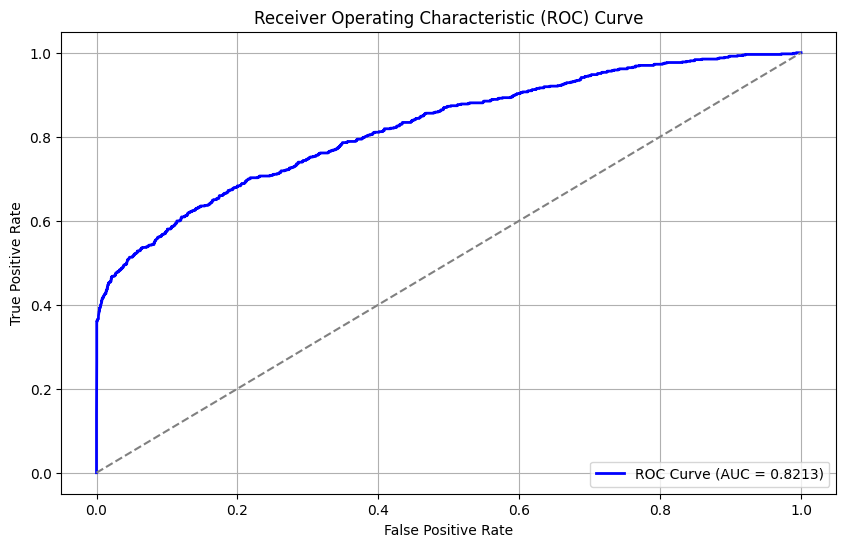

Optimal Threshold: 0.2038


In [850]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_lgm)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, ypred_proba_lgm):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.4f}')

In [1122]:
model_info = bst.dump_model()
trees = model_info['tree_info']

In [1123]:
trees

[{'tree_index': 0,
  'num_leaves': 75,
  'num_cat': 0,
  'shrinkage': 1,
  'tree_structure': {'split_index': 0,
   'split_feature': 9,
   'split_gain': 5757.72998046875,
   'threshold': 4.500000000000001,
   'decision_type': '<=',
   'default_left': True,
   'missing_type': 'None',
   'internal_value': -1.5016,
   'internal_weight': 0,
   'internal_count': 16000,
   'left_child': {'leaf_index': 0,
    'leaf_value': -0.9538377703466187,
    'leaf_weight': 177.6023030281067,
    'leaf_count': 1192},
   'right_child': {'split_index': 1,
    'split_feature': 16,
    'split_gain': 299.1910095214844,
    'threshold': 4.500000000000001,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': -1.54569,
    'internal_weight': 2206.32,
    'internal_count': 14808,
    'left_child': {'split_index': 2,
     'split_feature': 40,
     'split_gain': 134.63499450683594,
     'threshold': 999993.9881889765,
     'decision_type': '<=',
     'default_left': 

[ 2.  2.  2.  4.  5.  5.  5.  5.  5.  7.  8.  8.  8.  8.  8.  8.  9. 11.
 11. 14. 26.]


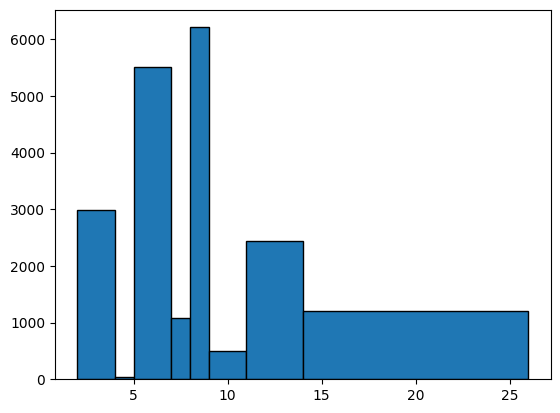

In [19]:
data = df['SHORT_TERM_COUNT']  # Replace with your dataset

# Number of bins
n_bins = 20

# Calculate quantiles
bin_edges = np.quantile(data, np.linspace(0, 1, n_bins + 1))
print(bin_edges)
# Plot histogram with the calculated bin edges
plt.hist(data, bins=bin_edges, edgecolor='black')
plt.show()